In [26]:
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
!tar xf spark-3.5.4-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

In [27]:
# Import findspark and initialise.
import findspark
findspark.init()

In [28]:
from google.colab import files
uploaded = files.upload()

Saving PS_Dataset.csv to PS_Dataset (1).csv


In [29]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("ExoPlanet_ETL_Project").getOrCreate()

In [30]:
file_path = "/content/PS_Dataset.csv"

df = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)
df.show(5)

+-----------+---------+------------+---------+-----------+----------------+--------------+--------------------+-------------------+------------------+--------------------+-------------------+--------------------------+--------------------------+-------------------------+-------------------+---------------------------+---------------------------+--------------------------+-------------------+-----------+-----------+----------+-------+-----------+-----------+----------+-----------------+-------------+-------------+------------+---------+-------------+-------------+------------+------------+--------------------+-------------------+--------------------+--------------+-----------------+------------------+-------------------+-----------+-----------------------+----------+----------+---------+--------+--------------------+-----------+------------------+-----------+-----------+----------+-----------------+----------+----------+---------+---------------+-----------+-----------+----------+------

In [31]:
# Import necessary libraries
from pyspark.sql.types import IntegerType, DoubleType, DateType
from pyspark.sql.functions import col, isnan, when, count, monotonically_increasing_id
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

+-------------+----------+
|  Planet_Name|prediction|
+-------------+----------+
|  BD+20 594 b|         1|
|     K2-263 b|         1|
|   TOI-3071 b|         0|
|    TOI-558 b|         0|
|  HD 136352 d|         1|
| Kepler-323 b|         1|
|  Kepler-53 b|         1|
|OGLE-TR-113 b|         0|
|   TOI-1694 b|         1|
|   HAT-P-37 b|         0|
+-------------+----------+
only showing top 10 rows



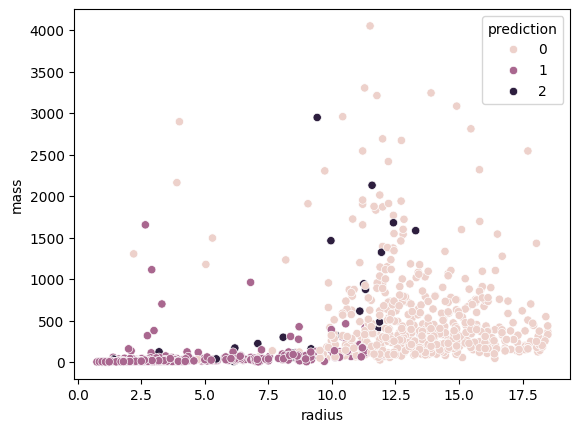

In [33]:
# --- Question 1: Clustering Exoplanets ---
df = df.withColumnRenamed("Planet_Radius_Earth", "radius").withColumnRenamed("Planet_Mass_Earth", "mass").withColumnRenamed("Equilibrium_Temperature", "temperature").withColumnRenamed("Semi_Major_Axis_AU", "semi_major_axis")

features = ['radius', 'mass', 'temperature', 'semi_major_axis']
vector_assembler = VectorAssembler(inputCols=features, outputCol='features')
df_features = vector_assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
df_scaled = scaler.fit(df_features).transform(df_features)

kmeans = KMeans(featuresCol='scaledFeatures', k=3, seed=42)
kmeans_model = kmeans.fit(df_scaled)
df_clusters = kmeans_model.transform(df_scaled)
df_clusters.select('Planet_Name', 'prediction').show(10)

# Convert to pandas for visualisation
df_clusters_pd = df_clusters.toPandas()
sns.scatterplot(data=df_clusters_pd, x=df_clusters_pd['radius'], y=df_clusters_pd['mass'], hue=df_clusters_pd['prediction'])
plt.savefig("clustering_visualization.png")
plt.show()

# Save the results
df_clusters.toPandas().to_csv("clustering_results.csv", index=False)


Classification Accuracy: 0.9752212389380531


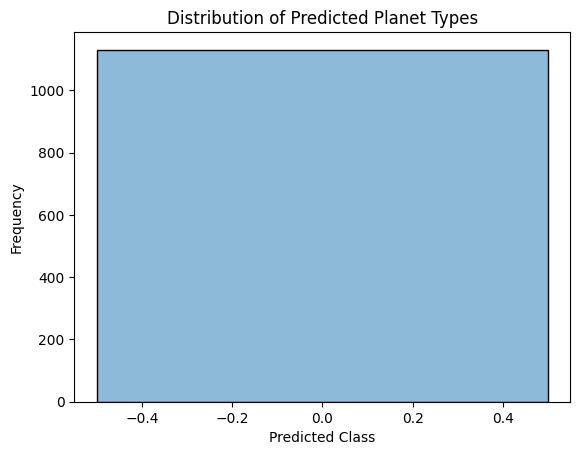

In [34]:
# --- Question 2: Classification of Planets ---
df_class = df.select('radius', 'mass', 'temperature', 'Discovery_Method')

# Convert string column to numeric
indexer = StringIndexer(inputCol="Discovery_Method", outputCol="Discovery_Method_Index")
df_class = indexer.fit(df_class).transform(df_class)

vector_assembler_class = VectorAssembler(inputCols=['radius', 'mass', 'temperature'], outputCol='features')
df_class_features = vector_assembler_class.transform(df_class)

rf = RandomForestClassifier(labelCol='Discovery_Method_Index', featuresCol='features', numTrees=10)
rf_model = rf.fit(df_class_features)
df_pred = rf_model.transform(df_class_features)

evaluator = MulticlassClassificationEvaluator(labelCol="Discovery_Method_Index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(df_pred)
print(f"Classification Accuracy: {accuracy}")


#Convert to Pandas for Visualisation
df_pred_pd = df_pred.select("Discovery_Method_Index", "prediction").toPandas()
sns.histplot(data=df_pred_pd, x='prediction', kde=True)
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Planet Types")
plt.savefig("classification_visualization.png")
plt.show()


# Save classification results
df_pred.toPandas().to_csv("classification_results.csv", index=False)



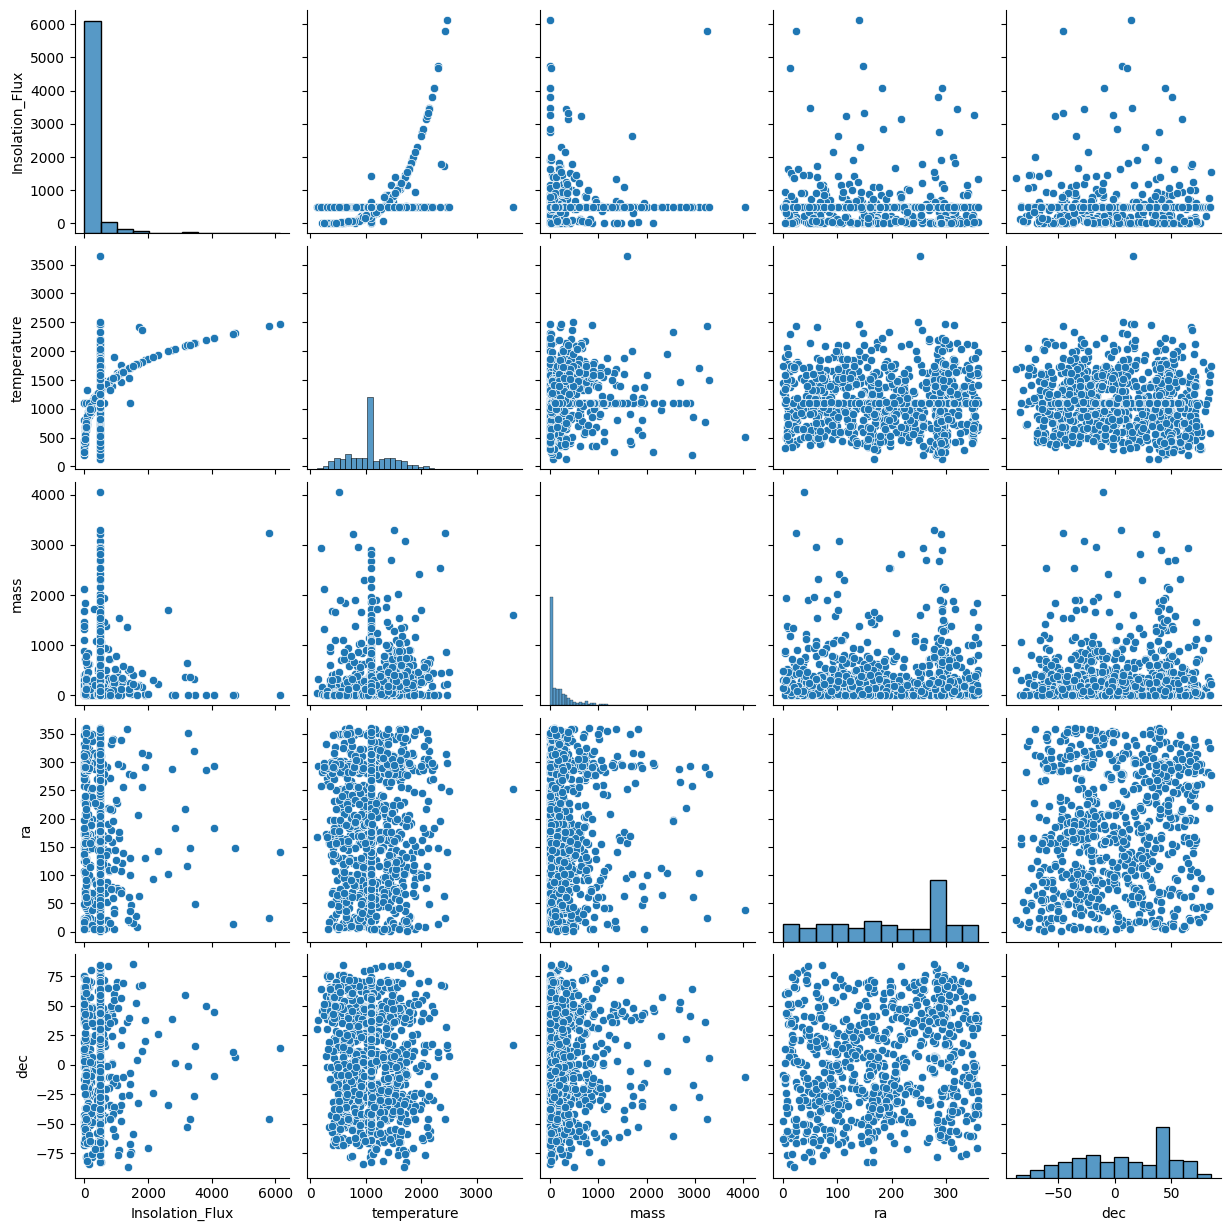

In [35]:
# --- Question 3 & 4: Classification by Insolation, Temperature, Mass, Coordinates ---
df_class2 = df.select('Insolation_Flux', 'temperature', 'mass', 'ra', 'dec')

#Convert to Pandas for Visualisation
df_class2_pd = df_class2.toPandas()
sns.pairplot(df_class2_pd)
plt.savefig("classification_insolation_temp_mass_coordinates.png")
plt.show()

#Save the Results
df_class2.toPandas().to_csv("classification_insolation_temp_mass_coordinates.csv", index=False)


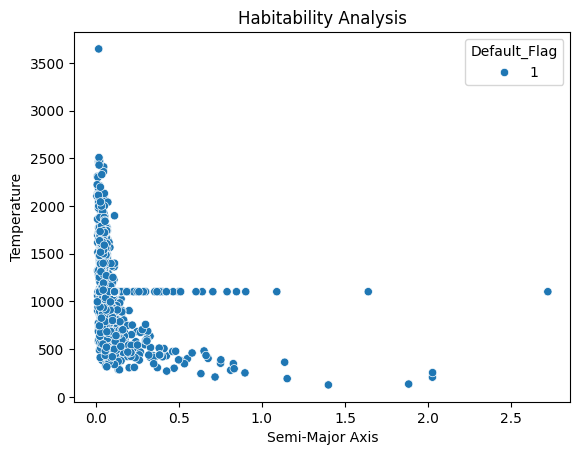

In [37]:
#  --- Question 5: Habitability Analysis ---
df_habitable = df.select('semi_major_axis', 'temperature', 'Default_Flag')

#Convert to Pandas for Visualisation
df_habitable_pd = df_habitable.toPandas()

sns.scatterplot(data=df_habitable_pd, x='semi_major_axis', y='temperature', hue='Default_Flag')
plt.xlabel("Semi-Major Axis")
plt.ylabel("Temperature")
plt.title("Habitability Analysis")
plt.savefig("habitability_analysis.png")
plt.show()

#Save the Results
df_habitable_pd.to_csv("habitability_analysis.csv", index=False)


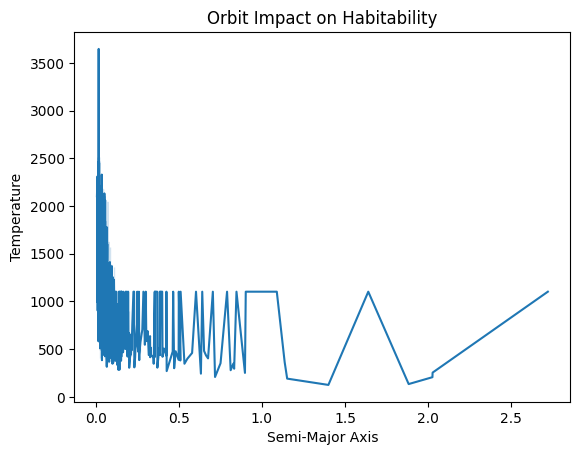

In [38]:
# --- Question 6: Orbit Impact on Habitability ---
df_orbit = df.select('semi_major_axis', 'temperature')


#Convert to Pandas for Visualisation
df_orbit_pd = df_orbit.toPandas()

sns.lineplot(data=df_orbit_pd, x='semi_major_axis', y='temperature')
plt.xlabel("Semi-Major Axis")
plt.ylabel("Temperature")
plt.title("Orbit Impact on Habitability")
plt.savefig("orbit_temperature_analysis.png")
plt.show()

#Save the Results
df_orbit_pd.to_csv("orbit_temperature_analysis.csv", index=False)

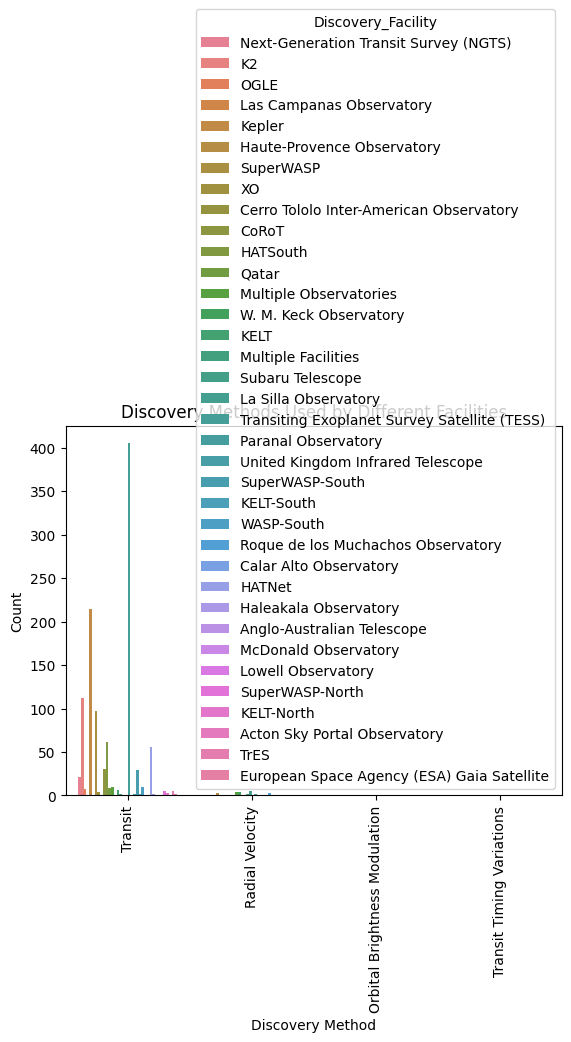

In [36]:
# --- Question 7: Discovery Facility & Detection Method Analysis ---
df_grouped = df.groupBy("Discovery_Facility", "Discovery_Method").count()

#Convert to Pandas for Visualisation
df_grouped_pd = df_grouped.toPandas()
sns.barplot(data=df_grouped_pd, x='Discovery_Method', y='count', hue='Discovery_Facility')
plt.xticks(rotation=90)
plt.xlabel("Discovery Method")
plt.ylabel("Count")
plt.title("Discovery Methods Used by Different Facilities")
plt.savefig("discovery_facility_method_analysis.png")
plt.show()

#Save the Results
df_grouped.toPandas().to_csv("discovery_facility_method_analysis.csv", index=False)

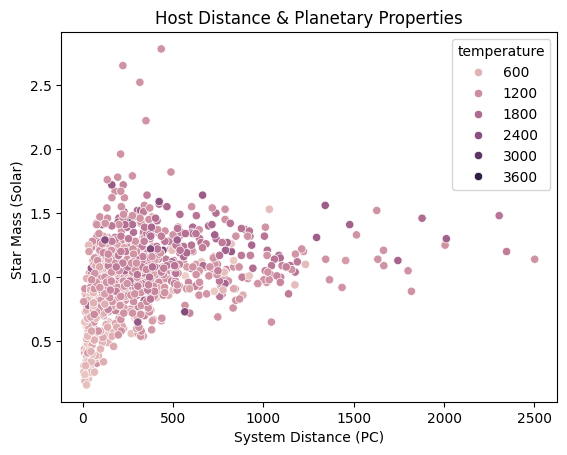

In [39]:
 #--- Question 8: Host Distance & Planetary Properties ---
df_host_distance = df.select('System_Distance_PC', 'Star_Mass_Solar', 'temperature')

#Convert to Pandas for Visulisation
df_host_distance_pd = df_host_distance.toPandas()

sns.scatterplot(data=df_host_distance_pd, x='System_Distance_PC', y='Star_Mass_Solar', hue='temperature')
plt.xlabel("System Distance (PC)")
plt.ylabel("Star Mass (Solar) ")
plt.title("Host Distance & Planetary Properties")
plt.savefig("host_distance_analysis.png")
plt.show()

# Save the Results
df_host_distance_pd.to_csv("host_distance_analysis.csv", index=False)

In [40]:
# Stop Spark session
spark.stop()